In [18]:
!pip install trimesh
!pip install torch
import os
import trimesh
import glob
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
device = tf.config.list_physical_devices('GPU')
print('GPU Available', len(device))
tf.config.experimental.set_memory_growth(device[0], True)

GPU Available 1


In [4]:
sydney_datast = keras.utils.get_file(
    "sydney-urban-objects-dataset.tar.gz",
    "http://www.acfr.usyd.edu.au/papers/data/sydney-urban-objects-dataset.tar.gz",
    extract=True
)
sydney_datast = os.path.join(os.path.dirname(sydney_datast), 'sydney-urban-objects-dataset')


In [5]:
print(sydney_datast)
import os
print(os.listdir('/root/.keras/datasets/sydney-urban-objects-dataset_extracted/sydney-urban-objects-dataset/objects'))

/root/.keras/datasets/sydney-urban-objects-dataset
['pedestrian.59.2299.bin.meta', 'truck.2.11290.csv', 'pedestrian.6.5463.bin.meta', '4wd.14.5229.bin', 'car.25.17038.bin', 'trunk.35.8254.bin', 'car.79.11204.bin.meta', 'bicycle.0.10974.csv', 'traffic_lights.28.7288.csv', 'pedestrian.12.6994.bin.meta', 'traffic_sign.35.5100.bin.meta', 'traffic_lights.15.6994.csv', '4wd.4.17038.csv', 'pedestrian.111.5100.bin.meta', 'van.24.6123.bin', 'car.32.5463.csv', '4wd.7.16217.csv', 'pedestrian.141.8254.bin.meta', 'cyclist.2.7288.csv', 'building.10.2446.bin', 'van.27.8254.csv', 'car.49.17589.csv', 'pedestrian.147.8444.csv', 'car.79.11204.csv', 'car.16.7288.bin', 'car.33.8254.bin', 'pedestrian.68.3582.csv', 'tree.28.20631.bin', 'bus.12.270.csv', 'van.0.6994.bin', 'traffic_lights.32.8254.csv', 'truck.8.5563.bin', 'trunk.0.17589.bin.meta', 'pedestrian.3.5463.bin.meta', 'tree.4.17038.csv', 'pedestrian.28.6994.bin.meta', 'traffic_sign.21.2299.csv', 'traffic_sign.49.12715.csv', 'pedestrian.115.5229.bin', 

In [24]:
def read_bin(file_name):

    names = ['t','intensity','id','x','y','z','azimuth','range','pid']

    formats = ['int64', 'uint8', 'uint8',
               'float32', 'float32', 'float32',
               'float32', 'float32', 'int32']

    binType = np.dtype( dict(names=names, formats=formats) )
    data = np.fromfile(file_name, binType)

    # 3D points, one per row
    P = np.vstack([ data['x'], data['y'], data['z'] ]).T

    return P

sample = read_bin('/root/.keras/datasets/sydney-urban-objects-dataset_extracted/sydney-urban-objects-dataset/objects/4wd.2.3582.bin')
print(sample.shape)

(204, 3)


In [7]:
labels_dict = {
    '4wd': 0,
    'bench': 1,
    'bicycle': 2,
    'biker': 3,
    'building': 4,
    'bus': 5,
    'car': 6,
    'cyclist': 7,
    'excavator': 8,
    'pedestrian': 9,
    'pillar': 10,
    'pole': 11,
    'post': 12,
    'scooter': 13,
    'ticket_machine': 14,
    'traffic_lights': 15,
    'traffic_sign': 16,
    'trailer': 17,
    'trash': 18,
    'tree': 19,
    'truck': 20,
    'trunk': 21,
    'umbrella': 22,
    'ute': 23,
    'van': 24,
    'vegetation': 25
}

num_classes = len(labels_dict)
num_classes

26

In [48]:
def sub_sample(pcs, labels, k):
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=k))
    pcs = res[:, 0:-1]
    labels = res[:, -1]
    labels -= 1
    return pcs, labels

class SydneyUrban(Dataset):
  def __init__(self, transform = False):
    self.files = []
    self.labels = []
    self.sample_size = 50

    folders = glob.glob('/root/.keras/datasets/sydney-urban-objects-dataset_extracted/sydney-urban-objects-dataset/objects')
    files = glob.glob(folders[0] + "/*")
    for file in files:
        file_name = file.split("/")[-1]
        if file_name.split(".")[-1] == "bin":
            label = file_name.split(".")[0]
            self.labels.append(labels_dict[label])
            self.files.append(file)

  def __len__(self):
      return len(self.files)

  def __getitem__(self, idx):
      pts_path = self.files[idx]
      label = self.labels[idx]

      pts = read_bin(pts_path)
      label = [label]*len(pts)
      label = np.array(label)

      pts, label = sub_sample(pts, label, self.sample_size)
      label = label[0]+1
      #label = np.expand_dims(label, 1)
      return {'points': np.array(pts, dtype="float32"), 'labels': label.astype(int)}

In [49]:
from sklearn.model_selection import train_test_split
dataset = SydneyUrban()

train, test = train_test_split(dataset, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

print(len(dataset))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

631
7
2
2


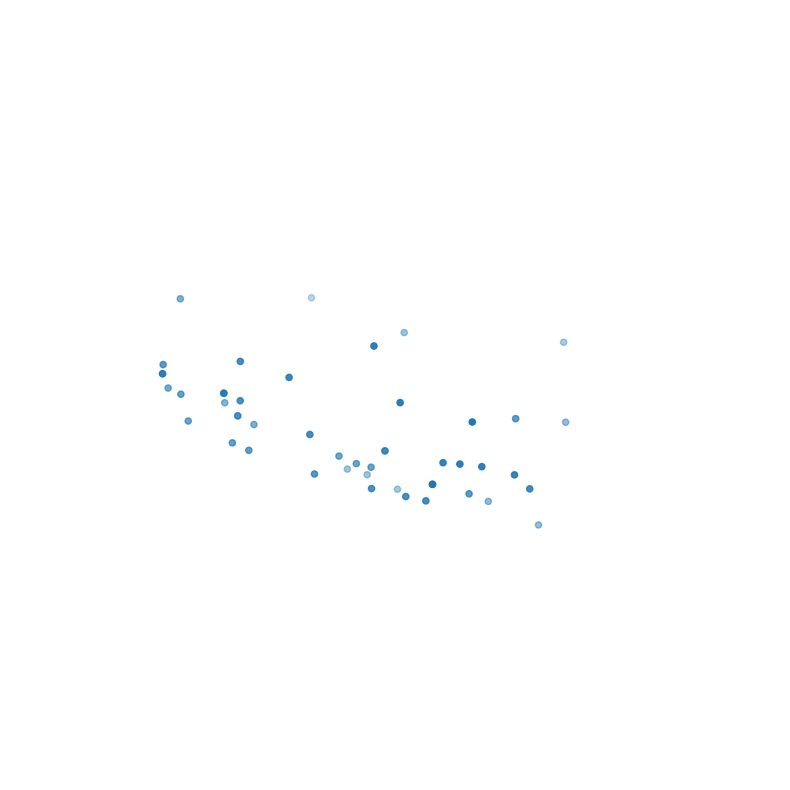

6


In [50]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train[0]['points'][:, 0], train[0]['points'][:, 1], train[0]['points'][:, 2])
ax.set_axis_off()
plt.show()
print(train[0]['labels'])